### Task 2 (1st dataset)
Requirement for the dataset: At least the size of one data is larger than your available memory. The
purpose of the requirement if that the implementation of the algorithm should be disk based and is
able to handle dataset of large size, i.e., it cannot assume that the data can fit into memory. As some
of you asked what would be the size of data, it is suggested that the data should be at least 4GB for
experiments.

**Subtasks**
1) document the dataset description, and the URL of the dataset where you download
2) report the running time results with different min-sup threshold, and the number of frequent itemsets, and the largest size of frequent itemsets. 

Code description:
Answers for Task 2 is split into two parts. The large dataset which is about 5 GB is implemented in the kaggle kernel and is in a separate .ipynb file. The analysis for the other 2 datasets are in a separate file.

In [1]:
pip install efficient_apriori

Note: you may need to restart the kernel to use updated packages.


In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from mpl_toolkits.mplot3d import Axes3D
import networkx as nx
from sklearn.preprocessing import StandardScaler
import os
from efficient_apriori import apriori as ap

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
def get_df_from_json(data_file_path):
    data_file = open(data_file_path, 'r', encoding='utf-8')
    data = []
    # Get the total number of lines in the file for tqdm
    for line in data_file:
        data.append(json.loads(line))
    data_file.close()
    return pd.DataFrame.from_dict(data, orient='columns')

def data_generator(df):
        for _, row in df.dropna().iterrows():
            transaction = frozenset(str(item) for item in row)
            yield transaction


#### Dataset: Reviews from Yelp Challenge Dataset (5GB)

**Context**

This dataset is a subset of Yelp's businesses, reviews, and user data. It was originally put together for the Yelp Dataset Challenge which is a chance for students to conduct research or analysis on Yelp's data and share their discoveries. In the most recent dataset you'll find information about businesses across 8 metropolitan areas in the USA and Canada.


**Content**

This dataset contains five JSON files and the user agreement.
Source: https://www.yelp.com/dataset


**Preface**

For analysis, we use the review.json.

In [4]:
review_df1 = get_df_from_json('/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json' )
review_df1.head(5)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [5]:
review_df = review_df1

In [6]:
review_df['useful'].replace({1: 'useful'}, inplace=True)
review_df['useful'].replace({0: 'not_useful'}, inplace=True)

review_df['funny'].replace({1: 'funny'}, inplace=True)
review_df['funny'].replace({0: 'not_funny'}, inplace=True)

review_df['cool'].replace({1: 'cool'}, inplace=True)
review_df['cool'].replace({0: 'not_cool'}, inplace=True)

In [7]:
review_df['stars'] = review_df['stars'].apply(lambda x: f"{'stars'}_{x}")

In [8]:
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,stars_3.0,not_useful,not_funny,not_cool,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,stars_5.0,useful,not_funny,cool,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,stars_3.0,not_useful,not_funny,not_cool,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,stars_5.0,useful,not_funny,cool,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,stars_4.0,useful,not_funny,cool,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [9]:
has_nan = review_df.isna().any().any()
if has_nan:
    print("The DataFrame contains NaN values.")
else:
    print("The DataFrame does not contain any NaN values.")

The DataFrame does not contain any NaN values.


In [10]:
transactions = data_generator(review_df)
# Iterate over the generator
itemsets, rules = ap(transactions, min_support=0.001, min_confidence=0.001, verbosity = 1)

Generating itemsets.
 Counting itemsets of length 1.
  Found 22933304 candidate itemsets of length 1.
  Found 28 large itemsets of length 1.
 Counting itemsets of length 2.
  Found 378 candidate itemsets of length 2.
  Found 129 large itemsets of length 2.
 Counting itemsets of length 3.
  Found 426 candidate itemsets of length 3.
  Found 194 large itemsets of length 3.
 Counting itemsets of length 4.
  Found 165 candidate itemsets of length 4.
  Found 73 large itemsets of length 4.
 Counting itemsets of length 5.
  Found 0 candidate itemsets of length 5.
Itemset generation terminated.

Generating rules from itemsets.
 Generating rules of size 2.
 Generating rules of size 3.
 Generating rules of size 4.
Rule generation terminated.



In [11]:
print("Number of lengths for frequent itemsets: ", len(itemsets))
print("Rules identified: ", len(rules))

Number of lengths for frequent itemsets:  4
Rules identified:  2444


In [12]:
#itemsets

In [13]:
# Convert the dictionary to a Pandas DataFrame
df_frequent_itemsets = pd.DataFrame([(item, len(item), support) for length, items in itemsets.items() for item, support in items.items()], columns=['Itemset', 'Length', 'Support'])

# Display the DataFrame
print(df_frequent_itemsets)

                                      Itemset  Length  Support
0                               (not_useful,)       1  3840492
1                                 (not_cool,)       1  5377964
2                                (not_funny,)       1  5894117
3                                (stars_3.0,)       1   691934
4                                (stars_5.0,)       1  3231627
..                                        ...     ...      ...
419  (not_cool, not_funny, stars_1.0, useful)       4   174776
420  (not_cool, not_funny, stars_2.0, useful)       4    89964
421  (not_cool, not_funny, stars_3.0, useful)       4   103831
422  (not_cool, not_funny, stars_4.0, useful)       4   177293
423  (not_cool, not_funny, stars_5.0, useful)       4   396683

[424 rows x 3 columns]


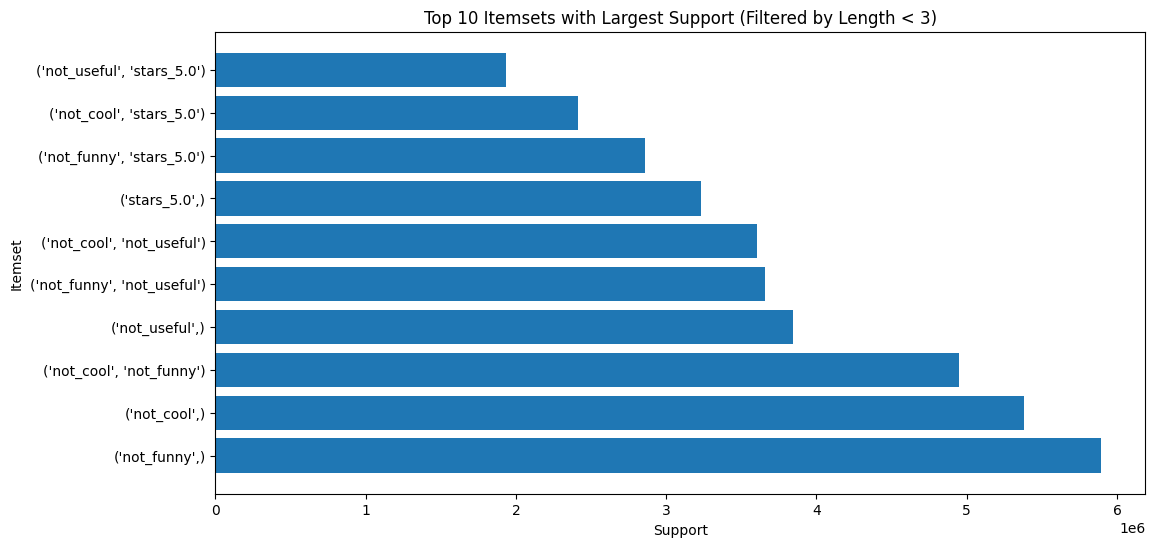

In [14]:
# Filter the DataFrame for itemsets with length < 3
filtered_df = df_frequent_itemsets[df_frequent_itemsets['Length'] < 3]

# Sort the filtered DataFrame by the 'Support' column
filtered_df = filtered_df.sort_values(by='Support', ascending=False)

# Get the top 10 itemsets with the largest support
top_itemsets = filtered_df.nlargest(10, 'Support')
# Plotting a horizontal bar chart for support of each itemset
plt.figure(figsize=(12, 6))
plt.barh(top_itemsets['Itemset'].astype(str), top_itemsets['Support'])
plt.xlabel('Support')
plt.ylabel('Itemset')
plt.title(f'Top {10} Itemsets with Largest Support (Filtered by Length < 3)')
plt.show()

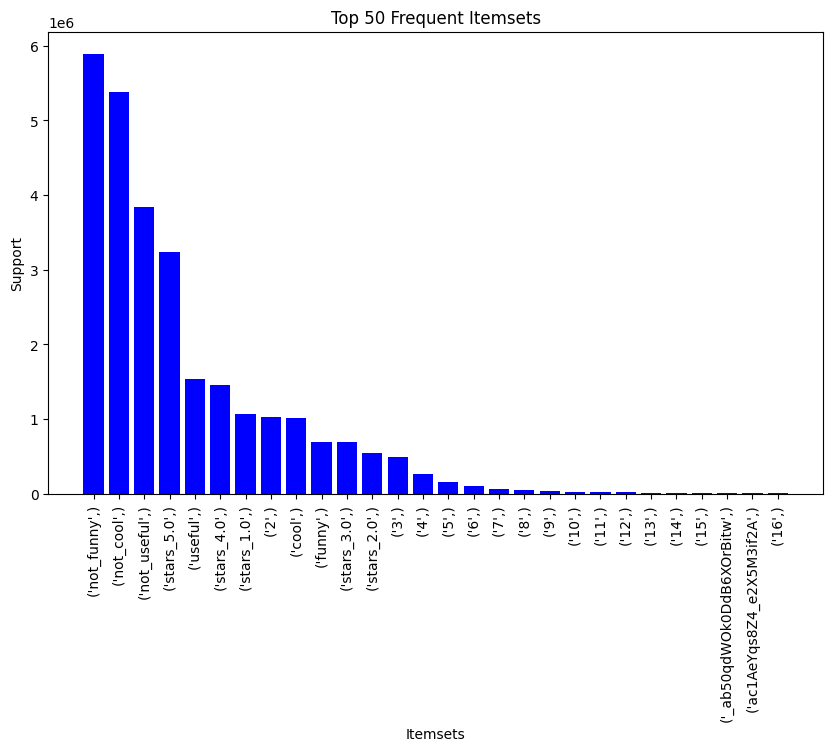

In [15]:
top_itemsets = sorted(itemsets[1].items(), key=lambda x: x[1], reverse=True)[:50]
itemset_names = [str(itemset[0]) for itemset in top_itemsets]
support_values = [support for _, support in top_itemsets]

# Plotting frequent itemsets
plt.figure(figsize=(10, 6))
plt.bar(itemset_names, support_values, color='blue')
plt.xlabel('Itemsets')
plt.ylabel('Support')
plt.title('Top 50 Frequent Itemsets')
plt.xticks(rotation=90)
plt.show()

In [16]:
filtered_rules = [rule for rule in rules if len(rule.lhs) + len(rule.rhs) > 3]

for i, rule in enumerate(filtered_rules[:10]):
    print(rule)

{3, funny, stars_4.0} -> {2} (conf: 0.294, supp: 0.001, lift: 2.000, conv: 1.208)
{2, funny, stars_4.0} -> {3} (conf: 0.157, supp: 0.001, lift: 2.221, conv: 1.102)
{2, 3, stars_4.0} -> {funny} (conf: 0.208, supp: 0.001, lift: 2.105, conv: 1.138)
{2, 3, funny} -> {stars_4.0} (conf: 0.332, supp: 0.001, lift: 1.597, conv: 1.186)
{funny, stars_4.0} -> {2, 3} (conf: 0.050, supp: 0.001, lift: 2.815, conv: 1.034)
{3, stars_4.0} -> {2, funny} (conf: 0.065, supp: 0.001, lift: 2.448, conv: 1.041)
{3, funny} -> {2, stars_4.0} (conf: 0.076, supp: 0.001, lift: 2.243, conv: 1.046)
{2, stars_4.0} -> {3, funny} (conf: 0.032, supp: 0.001, lift: 2.243, conv: 1.018)
{2, funny} -> {3, stars_4.0} (conf: 0.040, supp: 0.001, lift: 2.448, conv: 1.025)
{2, 3} -> {funny, stars_4.0} (conf: 0.060, supp: 0.001, lift: 2.815, conv: 1.041)


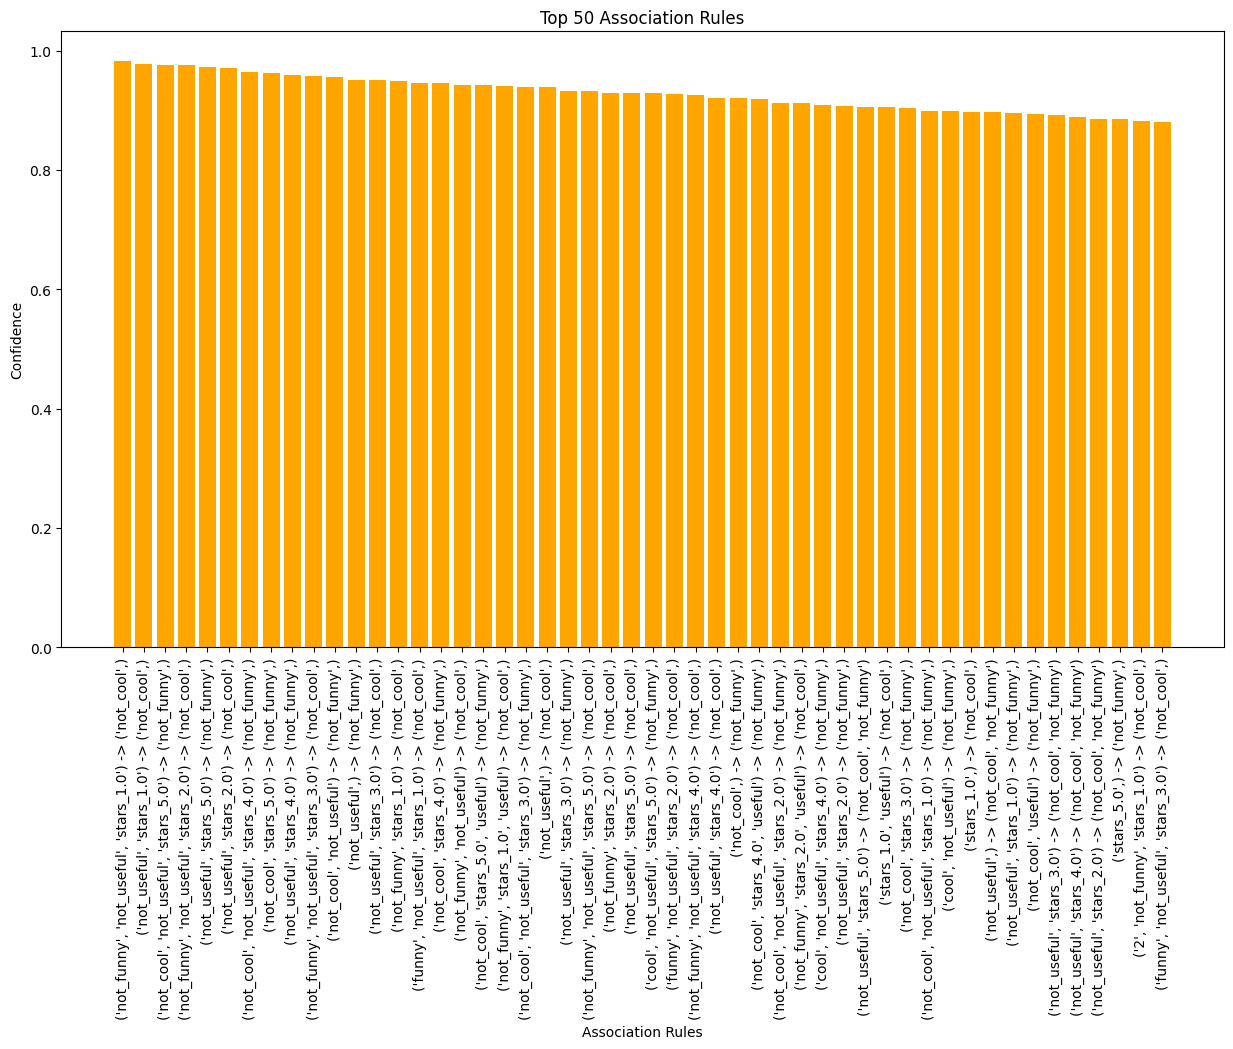

In [17]:
top_rules = sorted(rules, key=lambda x: x.confidence, reverse=True)[:50]
rule_names = [f"{str(rule.lhs)} -> {str(rule.rhs)}" for rule in top_rules]
confidence_values = [rule.confidence for rule in top_rules]

# Plotting association rules
plt.figure(figsize=(15, 8))
plt.bar(rule_names, confidence_values, color='orange')
plt.xlabel('Association Rules')
plt.ylabel('Confidence')
plt.title('Top 50 Association Rules')
plt.xticks(rotation=90)
plt.show()

In [18]:
# Sort rules based on lift
sorted_rules = sorted(rules, key=lambda rule: rule.lift)

# Extract relevant information for each rule
data = [{'Antecedent': rule.lhs, 'Consequent': rule.rhs, 'Confidence': rule.confidence,
         'Support': rule.support, 'Lift': rule.lift, 'Conviction': rule.conviction}
        for rule in sorted_rules]
# Create a DataFrame from the list of dictionaries
df_sorted_rules = pd.DataFrame(data)

# Display the sorted rules DataFrame
print(df_sorted_rules)

                   Antecedent               Consequent  Confidence   Support  \
0               (not_useful,)                     (3,)    0.002277  0.001251   
1                        (3,)            (not_useful,)    0.017750  0.001251   
2     (not_funny, not_useful)                     (2,)    0.004788  0.002503   
3                        (2,)  (not_funny, not_useful)    0.017022  0.002503   
4      (not_cool, not_useful)                     (2,)    0.005521  0.002847   
...                       ...                      ...         ...       ...   
2439                     (5,)                     (6,)    0.081296  0.001852   
2440                     (7,)                     (5,)    0.132692  0.001313   
2441                     (5,)                     (7,)    0.057633  0.001313   
2442                     (7,)                     (6,)    0.116064  0.001148   
2443                     (6,)                     (7,)    0.078429  0.001148   

          Lift  Conviction  
0     0.03

In [19]:
# Calculate the total number of itemsets
total_itemsets = sum(len(level_itemsets) for level_itemsets in itemsets.values())

# Display the result
print("Total number of itemsets:", total_itemsets)

# Find the largest itemset
largest_itemset = max(itemsets.values(), key=lambda x: max(len(itemset) for itemset in x), default=None)
size = len(largest_itemset)

# Display the result
print("Size of the largest itemset:", size)

Total number of itemsets: 424
Size of the largest itemset: 73


In [20]:
import time

# List of different min_support values to test
min_support_values = [0.0009, 0.001, 0.002, 0.003]

# Iterate over min_support values
for min_support in min_support_values:
    
    transactions = data_generator(review_df)
    start_time = time.time()
    # Run the Apriori algorithm
    itemsets, _ = ap(transactions, min_support=min_support, min_confidence=0.1)
    end_time = time.time()
    # Calculate the runtime
    runtime = end_time - start_time

    # Calculate the total number of itemsets
    total_itemsets = sum(len(level_itemsets) for level_itemsets in itemsets.values())
    # Find the largest itemset
    largest_itemset = max(itemsets.values(), key=lambda x: max(len(itemset) for itemset in x), default=None)
    # Find the size of the largest itemset
    largest_itemset_size = max(len(itemset) for level_itemsets in itemsets.values() for itemset in level_itemsets)


    # Display the results
    print(f"Min Support: {min_support}")
    print(f"Number of Frequent Itemsets: {total_itemsets}")
    print(f"Largest Size of Frequent Itemsets: {largest_itemset_size}")
    print(f"Runtime: {runtime:.4f} seconds")
    print("\n" + "="*50 + "\n")

Min Support: 0.0009
Number of Frequent Itemsets: 445
Largest Size of Frequent Itemsets: 4
Runtime: 604.3172 seconds


Min Support: 0.001
Number of Frequent Itemsets: 424
Largest Size of Frequent Itemsets: 4
Runtime: 597.3804 seconds


Min Support: 0.002
Number of Frequent Itemsets: 312
Largest Size of Frequent Itemsets: 4
Runtime: 589.7363 seconds


Min Support: 0.003
Number of Frequent Itemsets: 258
Largest Size of Frequent Itemsets: 4
Runtime: 580.9374 seconds




In [21]:
# List of different min_support values to test
min_support_values = [0.006, 0.01, 0.05]

# Iterate over min_support values
for min_support in min_support_values:
    
    transactions = data_generator(review_df)
    start_time = time.time()
    # Run the Apriori algorithm
    itemsets, _ = ap(transactions, min_support=min_support, min_confidence=0.1)
    end_time = time.time()
    # Calculate the runtime
    runtime = end_time - start_time

    # Calculate the total number of itemsets
    total_itemsets = sum(len(level_itemsets) for level_itemsets in itemsets.values())
    # Find the largest itemset
    largest_itemset = max(itemsets.values(), key=lambda x: max(len(itemset) for itemset in x), default=None)
    # Find the size of the largest itemset
    largest_itemset_size = max(len(itemset) for level_itemsets in itemsets.values() for itemset in level_itemsets)


    # Display the results
    print(f"Min Support: {min_support}")
    print(f"Number of Frequent Itemsets: {total_itemsets}")
    print(f"Largest Size of Frequent Itemsets: {largest_itemset_size}")
    print(f"Runtime: {runtime:.4f} seconds")
    print("\n" + "="*50 + "\n")

Min Support: 0.006
Number of Frequent Itemsets: 188
Largest Size of Frequent Itemsets: 4
Runtime: 584.7907 seconds


Min Support: 0.01
Number of Frequent Itemsets: 145
Largest Size of Frequent Itemsets: 4
Runtime: 575.4179 seconds


Min Support: 0.05
Number of Frequent Itemsets: 59
Largest Size of Frequent Itemsets: 4
Runtime: 554.0254 seconds




In [22]:
# List of different min_support values to test
min_support_values = [0.5, 0.8, 0.9]

# Iterate over min_support values
for min_support in min_support_values:
    
    transactions = data_generator(review_df)
    start_time = time.time()
    # Run the Apriori algorithm
    itemsets, _ = ap(transactions, min_support=min_support, min_confidence=0.1)
    end_time = time.time()
    # Calculate the runtime
    runtime = end_time - start_time

    # Calculate the total number of itemsets
    total_itemsets = sum(len(level_itemsets) for level_itemsets in itemsets.values())
    # Find the largest itemset
    largest_itemset = max(itemsets.values(), key=lambda x: max(len(itemset) for itemset in x), default=None)
    # Find the size of the largest itemset
    largest_itemset_size = max(len(itemset) for level_itemsets in itemsets.values() for itemset in level_itemsets)


    # Display the results
    print(f"Min Support: {min_support}")
    print(f"Number of Frequent Itemsets: {total_itemsets}")
    print(f"Largest Size of Frequent Itemsets: {largest_itemset_size}")
    print(f"Runtime: {runtime:.4f} seconds")
    print("\n" + "="*50 + "\n")

Min Support: 0.5
Number of Frequent Itemsets: 6
Largest Size of Frequent Itemsets: 2
Runtime: 525.7390 seconds


Min Support: 0.8
Number of Frequent Itemsets: 1
Largest Size of Frequent Itemsets: 1
Runtime: 523.8671 seconds




ValueError: max() arg is an empty sequence

No frequent itemsets are generated when min support is 0.9 and above. This is because no itemsets can meet the min support threshold.

From the results above, we can see that the number of frequent itemsets, largest size of an itemset and the runtime decrease as we reduce the min support. This trend is followed in the analysis of other datasets as well. From the formula 


*min support(I) = Number of transactions containing I/Total number of transactions*, 


we can infer that as min support is lowered, more candidate itemsets survive each iteration of the algorithm because fewer transactions are needed to meet the lower support threshold. This results in an increased number of candidates at each level, leading to a larger set of frequent itemsets. The rate of pruning of supersets of the infrequent itemsets also decreases, resulting in more itemsets meeting the min support threshold.

**Challenges faced**

Since we are dealing with a large dataset, the loading of the data was done in a Kaggle kernel where the dataset was already loaded in the Kaggle database. Additionally, in order to feed the data into the apriori algorithm, we created a data generator, which generates transactions, represented as frozensets. These are implemented using hash tables. The hash function in frozensets maps keys (in this case, the elements of the frozenset) to indices (buckets) in an array. 

